<a href="https://colab.research.google.com/github/pbrugierewebsite/QPM_Templates/blob/main/BookListing5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 6.4 MB 10.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()


annualised standard deviations of the returns:
DPW.DE    0.154050
ALV.DE    0.130898
BMW.DE    0.150094
BAS.DE    0.150738
FME.DE    0.169943
Name: 0, dtype: float64
annualised means of the returns:
DPW.DE    0.280040
ALV.DE    0.249389
BMW.DE    0.015178
BAS.DE    0.079054
FME.DE    0.091420
Name: 0, dtype: float64
min variance portfolio:
sd_a 0.11238766790304693 ,m_a 0.1478947103105287
matrix of variance-covariance:
          DPW.DE    ALV.DE    BMW.DE    BAS.DE    FME.DE
DPW.DE  0.023731  0.012276  0.010278  0.012597  0.010925
ALV.DE  0.012276  0.017134  0.009849  0.011937  0.008191
BMW.DE  0.010278  0.009849  0.022528  0.011679  0.007472
BAS.DE  0.012597  0.011937  0.011679  0.022722  0.010227
FME.DE  0.010925  0.008191  0.007472  0.010227  0.028881
Correl Matrix
          DPW.DE    ALV.DE    BMW.DE    BAS.DE    FME.DE
DPW.DE  1.000000  0.608765  0.444511  0.542464  0.417326
ALV.DE  0.608765  1.000000  0.501276  0.605001  0.368212
BMW.DE  0.444511  0.501276  1.000000  0.516218  0.2

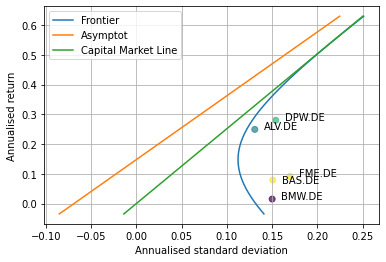

In [1]:
# Library importations
!pip install yfinance
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import math
from numpy import linalg as LA
from numpy.linalg import inv
from scipy import stats
#from matplotlib import pyplot as plt # delete for Python 3
import matplotlib.pyplot as plt # add for Python 3
fig, ax = plt.subplots()

# Data extraction
data = pd.Series()
TickerDax = ['DPW.DE','ALV.DE','BMW.DE','BAS.DE','FME.DE']
for x in TickerDax :
    data[x] = yf.Ticker(x).history(start='2017-01-1',end='2017-12-31')

# Variable creations
r=0 # risk-free rate
AFactor = len(data['DPW.DE'])-1 # annualisation factor, based on number of observations in a year
n_TickerDax = len(TickerDax) # nb of stocks considered
Vec1 = np.linspace(1, 1, n_TickerDax) # create a vector, with all components equal to 1
data_R = pd.DataFrame() # daily returns
Mdata_R = pd.DataFrame() # means of the daily returns
Sigma = pd.DataFrame() # variance-covariance matrix of the returns annualised
Sigma_diag = pd.DataFrame() # individual variances (derived from the variance-covariance matrix)

for x in TickerDax:  
    data_R[x] = (data[x]['Close']/data[x]['Close'].shift(1)-1)
Sigma = AFactor*data_R.cov() # annualisation, the missing values are not taken into account with .Cov()
InvSigma = inv(Sigma)  
for x in TickerDax:  
    Sigma_diag[x] = [Sigma[x][x]] 
    Mdata_R[x]= [float(np.mean(data_R[x])) ] 

# Model parameters, derived from the observations
Mean =  AFactor* Mdata_R.iloc[0] # average returns on an annualised basis 
STD = Sigma_diag.iloc[0]**.5 # standard deviations on an annualised basis

# Important variables calculation
a = Vec1.T.dot(InvSigma).dot(Vec1) 
b = Mean.T.dot(InvSigma).dot(Vec1) 
sd_a = 1 / math.sqrt(a) # standard deviation, minimum variance portfolio
m_a = b / a # expected return, minimum variance portfolio
m_w = math.sqrt((Mean - b/a * Vec1).T.dot(InvSigma).dot(Mean - b/a * Vec1)) # expected return, portfolio w
m_r = math.sqrt((Mean - r * Vec1).T.dot(InvSigma).dot(Mean - r * Vec1)) # expected return, Tangent Portfolio 

# Graph plotting
np.random.seed(7777) # Fixing random state for reproducibility
colors = np.random.rand(len(STD)) # each point will have its own (random) color
plt.scatter(STD, Mean, c=colors, alpha=0.7) # plot the assets, alpha transparency parameter
ax.annotate(TickerDax[0], (STD[0]+.01,Mean[0] ))
ax.annotate(TickerDax[1], (STD[1]+.01,Mean[1] ))
ax.annotate(TickerDax[2], (STD[2]+.01,Mean[2] ))
ax.annotate(TickerDax[3], (STD[3]+.01,Mean[3]-.01 ))
ax.annotate(TickerDax[4], (STD[4]+.01,Mean[4] ))
range_inf = np.min(Mean) - 0.05
range_sup = np.max(Mean) + 0.35
z2 = np.linspace(range_inf , range_sup, 50) # range of expected returns considered
z1 = pd.DataFrame() 
z= pd.DataFrame() 
zr= pd.DataFrame()
i=0
for i in range(len(z2)):
    z1[i]= [math.sqrt( ((z2[i]- m_a)/m_w)**2 + sd_a**2 )] # Frontier
    z[i]= [(z2[i] - b/a)/m_w] # Asymptot to the Frontier
    zr[i]= [(z2[i] - r)/m_r] # Capital Marlet Line
z1 = z1.iloc[0]
z=z.iloc[0]
zr=zr.iloc[0]
plt.plot(z1, z2, alpha=1) # plot the Frontier 
plt.plot(z, z2, alpha=1) # plot the asymptot to the Frontier 
plt.plot(zr, z2, alpha=1) # plot the Capital Market Line 
plt.legend(['Frontier','Asymptot','Capital Market Line' ], loc=2)
plt.grid(True)
plt.xlabel('Annualised standard deviation')
plt.ylabel('Annualised return')

# Useful Ouputs. 
print ("annualised standard deviations of the returns:") 
print (STD) 
print ("annualised means of the returns:")
print (Mean) 
print ("min variance portfolio:")
print ("sd_a", sd_a, ",m_a", b/a) 
print ("matrix of variance-covariance:")
print (Sigma)
print ("Correl Matrix")
print (data_R . corr ())